# <span style="color:#0073e6">0. 사례준비</span>
<style>
@media print
{
h1 {page-break-before:always}
}
</style>

> **Libaray & Environment Settings** 

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rc('axes', unicode_minus=False)
np.random.seed(123)
%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

> **MNIST DATA SET LOADING**

In [3]:
with open('mnist.pkl', 'rb') as f:
    _, _, t = pickle.load(f, encoding='latin1')
x, y = t[0], t[1]
del t
print(x.shape)
print(y.shape)

(10000, 784)
(10000,)


- - -
# <span style="color:#0073e6">1. 지도학습을 이용한 특성추출<span>
### 1.1. 출력층 바로 앞의 은닉층의 출력 추출
> **간단한 CNN 구현을 위한 데이터 준비**<br/>
>> `input_shape` = (10000, 28,28,1) <br/>
>> `output_shape` = (10000, 10)

In [4]:
num_class = 10
input_shape = (28, 28, 1)
num_dim = 100

In [5]:
x_train = x.reshape(10000,28,28,1)
y_train = to_categorical(y, num_class)
print(x_train.shape)
print(y_train.shape)

(10000, 28, 28, 1)
(10000, 10)


- - -
# <span style="color:#2EFE9A">.</span>

> **모델 정의**<br/>

In [6]:
model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(num_dim, activation="sigmoid"),
        Dense(num_class, activation="softmax"),
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

- - -
# <span style="color:#2EFE9A">.</span>

> **모델 학습**<br/>

In [7]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="RMSProp", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/15
79/79 [==============================] - 1s 8ms/step - loss: 0.8796 - accuracy: 0.7707
Epoch 2/15
79/79 [==============================] - 1s 7ms/step - loss: 0.2846 - accuracy: 0.9279
Epoch 3/15
79/79 [==============================] - 1s 7ms/step - loss: 0.1871 - accuracy: 0.9503
Epoch 4/15
79/79 [==============================] - 1s 7ms/step - loss: 0.1458 - accuracy: 0.9579
Epoch 5/15
79/79 [==============================] - 1s 7ms/step - loss: 0.1193 - accuracy: 0.9647
Epoch 6/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0998 - accuracy: 0.9717
Epoch 7/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0891 - accuracy: 0.9727
Epoch 8/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0810 - accuracy: 0.9743
Epoch 9/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0729 - accuracy: 0.9790
Epoch 10/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0652 - accuracy: 0.9797
Epoch 11/15
79/79 [

- - -
# <span style="color:#2EFE9A">.</span>

> **마지막 바로 이전 층 출력 추출**

In [8]:
model.layers

In [9]:
layer_outputs = [layer.output for layer in model.layers[:7]]
activ_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activ_model.predict(x_train)
cnn = activations[6]

ResourceExhaustedError: OOM when allocating tensor with shape[10000,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

### 1.2. 특성 추출 결과의 비교
> **PCA와 특성 비교**<br/>
>> PCA 학습

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=num_dim, whiten=False)
pca.fit(x)
x_pca = pca.transform(x)

- - -
# <span style="color:#2EFE9A">.</span>

>> tSNE를 통한 시각화 비교

In [11]:
from sklearn.manifold import TSNE
def t_scatter(x, y, ax):
    if x.shape[1]!=2:
        t = TSNE(n_components=2, learning_rate=300)
        x_t = t.fit_transform(x)
    else:
        x_t = x
    g = pd.DataFrame(x_t, columns=['Vector-1','Vector-2'])
    g['Label'] = y
    sns.scatterplot(x='Vector-1',y='Vector-2', hue='Label',
                           palette=sns.color_palette('Paired', 10), 
                           data=g, ax=ax)
    return x_t

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

pca_t = t_scatter(x_pca, y, ax[0])
cnn_t = t_scatter(cnn, y, ax[1])
ax[0].set_title('PCA')
ax[1].set_title('CNN');

- - -
# <span style="color:#0073e6">2. AutoEncoder<span>

### 2.2. 과소완전(undercomplete) 오토인코더<br/>

- - -
# <span style="color:#2EFE9A">.</span>

> **모델링**
>> 선형오토인코더와 비선형오토인코더 비교

In [12]:
linear_auto = Sequential(
    [
        Input(shape=(x.shape[1],)), 
        Dense(num_dim, activation='linear'), 
        Dense(x.shape[1], activation='linear')
    ])
linear_auto.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
Total params: 157,684
Trainable params: 157,684
Non-trainable params: 0
_________________________________________________________________


In [13]:
nonlinear_auto = Sequential(
    [
        Input(shape=(x.shape[1],)), 
        Dense(num_dim, activation='relu'), 
        Dense(x.shape[1], activation='relu')
    ])
nonlinear_auto.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 157,684
Trainable params: 157,684
Non-trainable params: 0
_________________________________________________________________


- - -
# <span style="color:#2EFE9A">.</span>
- 모델 학습

In [14]:
epochs = 10
linear_auto.compile(loss="mean_squared_error", optimizer="RMSProp", metrics=["mse"])
linear_auto.fit(x, x, batch_size=batch_size, epochs=epochs)

Epoch 1/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0495 - mse: 0.0495
Epoch 2/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0229 - mse: 0.0229
Epoch 3/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0166 - mse: 0.0166
Epoch 4/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0137 - mse: 0.0137
Epoch 5/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0120 - mse: 0.0120
Epoch 6/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0108 - mse: 0.0108
Epoch 7/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0099 - mse: 0.0099
Epoch 8/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0093 - mse: 0.0093
Epoch 9/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0089 - mse: 0.0089
Epoch 10/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0085 - mse: 0.0085


In [15]:
nonlinear_auto.compile(loss="mean_squared_error", optimizer="RMSProp", metrics=["mse"])
nonlinear_auto.fit(x, x, batch_size=batch_size, epochs=epochs)

Epoch 1/10
79/79 [==============================] - 0s 1ms/step - loss: 0.0417 - mse: 0.0417
Epoch 2/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0233 - mse: 0.0233
Epoch 3/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0187 - mse: 0.0187
Epoch 4/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0164 - mse: 0.0164
Epoch 5/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0151 - mse: 0.0151
Epoch 6/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0141 - mse: 0.0141
Epoch 7/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0134 - mse: 0.0134
Epoch 8/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0128 - mse: 0.0128
Epoch 9/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0123 - mse: 0.0123
Epoch 10/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0118 - mse: 0.0118


- - -
# <span style="color:#2EFE9A">.</span>

In [16]:
def outputs(my_auto, encoder_loc):
    layer_outputs = [layer.output for layer in my_auto.layers[:encoder_loc]]
    activ_model = Model(inputs=my_auto.input, outputs=layer_outputs)
    activations = activ_model.predict(x)
    if type(activations)==list:
        activations = activations[encoder_loc-1]
    return activations

In [17]:
l_auto = outputs(linear_auto, 1)
nl_auto = outputs(nonlinear_auto, 1)

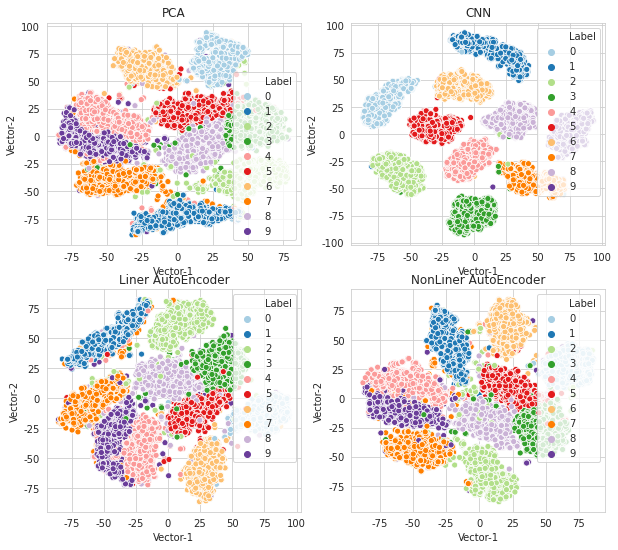

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,9))
pca_t = t_scatter(pca_t, y, ax[0,0])
cnn_t = t_scatter(cnn_t, y, ax[0,1])
linear_t = t_scatter(l_auto, y, ax[1,0])
nonlinear_t = t_scatter(nl_auto, y, ax[1,1])
ax[0,0].set_title('PCA')
ax[0,1].set_title('CNN')
ax[1,0].set_title('Liner AutoEncoder')
ax[1,1].set_title('NonLiner AutoEncoder');

- - -
# <span style="color:#2EFE9A">.</span>

### 2.3. 과대완전(overcomplete) 오토인코더

In [19]:
overcomp = Sequential(
    [
        Input(shape=(x.shape[1],)), 
        Dense(x.shape[1]*2, activation='relu'), 
        Dropout(0.1),
        Dense(num_dim, activation='relu'), 
        Dense(x.shape[1], activation='relu')
    ])
overcomp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1568)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               156900    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               79184     
Total params: 1,466,964
Trainable params: 1,466,964
Non-trainable params: 0
_________________________________________________________________


- - -
# <span style="color:#2EFE9A">.</span>

In [20]:
overcomp.compile(loss="mean_squared_error", optimizer="RMSProp", metrics=["mse"])
overcomp.fit(x, x, batch_size=batch_size, epochs=epochs)

Epoch 1/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0536 - mse: 0.0536
Epoch 2/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0311 - mse: 0.0311
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 0.0252 - mse: 0.0252
Epoch 4/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0223 - mse: 0.0223
Epoch 5/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0204 - mse: 0.0204
Epoch 6/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0190 - mse: 0.0190
Epoch 7/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0180 - mse: 0.0180
Epoch 8/10
79/79 [==============================] - 0s 3ms/step - loss: 0.0172 - mse: 0.0172
Epoch 9/10
79/79 [==============================] - 0s 3ms/step - loss: 0.0165 - mse: 0.0165
Epoch 10/10
79/79 [==============================] - 0s 3ms/step - loss: 0.0160 - mse: 0.0160


- - -
# <span style="color:#2EFE9A">.</span>

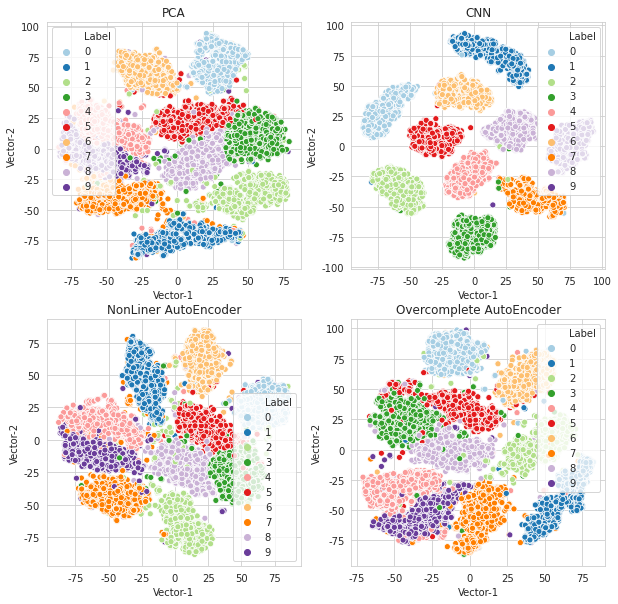

In [21]:
overcomp_auto = outputs(overcomp, 3)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

pca_t = t_scatter(pca_t, y, ax[0,0])
cnn_t = t_scatter(cnn_t, y, ax[0,1])
nonlinear_t = t_scatter(nonlinear_t, y, ax[1,0])
over_t = t_scatter(overcomp_auto, y, ax[1,1])
ax[0,0].set_title('PCA')
ax[0,1].set_title('CNN')
ax[1,0].set_title('NonLiner AutoEncoder')
ax[1,1].set_title('Overcomplete AutoEncoder');

- - -
# <span style="color:#2EFE9A">.</span>

### 2.4. 희소(Sparse) 오토인코더

In [22]:
sparse_over = Sequential(
    [
        Input(shape=(x.shape[1],)), 
        Dense(x.shape[1]*2, activation='relu', 
             activity_regularizer=regularizers.l1(0.001)), 
        Dropout(0.1),
        Dense(num_dim, activation='relu'), 
        Dense(x.shape[1], activation='relu')
    ])
sparse_over.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1568)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               156900    
_________________________________________________________________
dense_11 (Dense)             (None, 784)               79184     
Total params: 1,466,964
Trainable params: 1,466,964
Non-trainable params: 0
_________________________________________________________________


- - -
# <span style="color:#2EFE9A">.</span>

In [23]:
sparse_over.compile(loss="mean_squared_error", optimizer="RMSProp", metrics=["mse"])
sparse_over.fit(x, x, batch_size=batch_size, epochs=epochs)

Epoch 1/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0738 - mse: 0.0650
Epoch 2/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0536 - mse: 0.0486
Epoch 3/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0472 - mse: 0.0426
Epoch 4/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0437 - mse: 0.0393
Epoch 5/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0412 - mse: 0.0369
Epoch 6/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0398 - mse: 0.0356
Epoch 7/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0343
Epoch 8/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0373 - mse: 0.0332
Epoch 9/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0364 - mse: 0.0323
Epoch 10/10
79/79 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0315


- - -
# <span style="color:#2EFE9A">.</span>

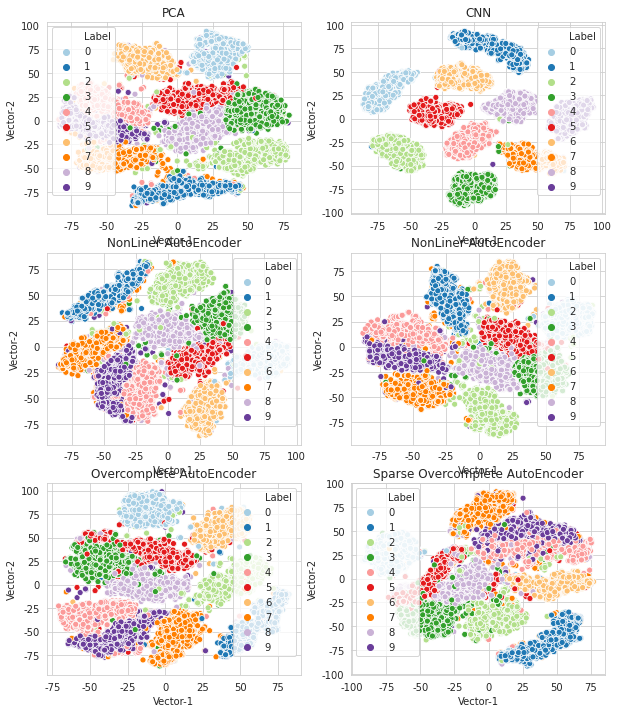

In [24]:
sparse_auto = outputs(sparse_over, 3)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,12))
pca_t = t_scatter(pca_t, y, ax[0,0])
cnn_t = t_scatter(cnn_t, y, ax[0,1])
linear_t = t_scatter(linear_t, y, ax[1,0])
nonlinear_t = t_scatter(nonlinear_t, y, ax[1,1])
over_t = t_scatter(over_t, y, ax[2,0])
sparse_t = t_scatter(sparse_auto, y, ax[2,1])
ax[0,0].set_title('PCA')
ax[0,1].set_title('CNN')
ax[1,0].set_title('NonLiner AutoEncoder')
ax[1,1].set_title('NonLiner AutoEncoder')
ax[2,0].set_title('Overcomplete AutoEncoder')
ax[2,1].set_title('Sparse Overcomplete AutoEncoder');